# Analisi Dati per l'esperienza di Millikan

### Import delle librerie

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scienceplots

plt.style.use(["science", "grid", "ieee"])

### Dati pre-misure

In [2]:
# Valori fisici
g = 9.806  # m/s^2
rho_o = 860  # kg/m^3
rho_a = 1.293  # kg/m^3
conv_atm_Pa = 101325  # Pa (from atm)
b = 8.2e-3  # Pa m (costante correzione viscosa)
reticolo = 0.5  # mm
d_isolante = 7.6  # mm

# File Excel
rows = 8
columns = 8
sheets = 6
max_sheets = 4
max_row = 5
max_col = 3

### Funzioni per i conti

In [3]:
def calc_visco(T: float) -> float:
    # T deve essere in celsius
    return (1.8 + 4.765e-3 * (T - 15)) * 1e-5  # N s m^-2


# inutile
def calc_visco_eff(nu: float, press: float, r_0: float) -> float:
    return nu / (1 + b / (press * r_0))


def calc_radius(nu: float, press: float, vel: np.ndarray) -> np.ndarray:
    # ! non sono sicuro che il calcolo del raggio sia corretto
    return np.sqrt(
        (b / (2 * press)) ** 2 + (9 * nu * np.abs(vel)) / (2 * g * (rho_o - rho_a))
    ) - b / (2 * press)
    # ? ma se rho cambia in fz della temperatura, qual'è l'errore che ne viene fuori?


def calc_charge(r: float, v_r: float, E: np.ndarray, v_E: np.ndarray) -> np.ndarray:
    return -4 / 3 * np.pi * r**3 * (rho_o - rho_a) * g * np.divide((1 + v_E / v_r), E)

### Import dei dati sperimentali

In [4]:
tempi = (
    pd.read_excel("Dati_Raccolti.xlsx", sheet_name="Tempi", header=None)
    .to_numpy()
    .reshape((sheets, columns, rows))  # to get a 3d matrix
    .transpose((0, 2, 1))  # to get the dimensions in the correct order
)
temperatura = pd.read_excel(
    "Dati_Raccolti.xlsx", sheet_name="Temperature", header=None
).to_numpy()
pressione = pd.read_excel(
    "Dati_Raccolti.xlsx", sheet_name="Pressioni", header=None
).to_numpy()
voltaggio = pd.read_excel(
    "Dati_Raccolti.xlsx", sheet_name="Voltaggi", header=None
).to_numpy()

print(tempi, temperatura, pressione, voltaggio, sep="\n\n")

[[[ 1.52e+01  1.56e+01  1.49e+01  1.49e+01  1.59e+01  0.00e+00  0.00e+00
    0.00e+00]
  [ 4.30e+00  4.40e+00  4.50e+00  4.20e+00  4.30e+00  0.00e+00  0.00e+00
    0.00e+00]
  [-1.03e+01 -1.04e+01 -1.04e+01 -1.05e+01 -1.04e+01  0.00e+00  0.00e+00
    0.00e+00]
  [ 1.50e+01  1.51e+01  1.52e+01  1.49e+01  1.50e+01  0.00e+00  0.00e+00
    0.00e+00]
  [ 1.90e+01  1.51e+01  1.52e+01  1.49e+01  1.50e+01  0.00e+00  0.00e+00
    0.00e+00]
  [ 1.50e+01  1.51e+01  1.52e+01  1.49e+01  1.50e+01  0.00e+00  0.00e+00
    0.00e+00]
  [ 1.50e+01  1.51e+01  1.52e+01  1.49e+01  1.50e+01  0.00e+00  0.00e+00
    0.00e+00]
  [ 1.50e+01  1.51e+01  1.52e+01  1.49e+01  1.50e+01  0.00e+00  0.00e+00
    0.00e+00]]

 [[ 1.15e+01  1.13e+01  1.12e+01  1.14e+01  1.17e+01  0.00e+00  0.00e+00
    0.00e+00]
  [ 2.70e+00  2.60e+00  2.80e+00  2.70e+00  2.90e+00  0.00e+00  0.00e+00
    0.00e+00]
  [-5.40e+00 -5.30e+00 -6.40e+00 -7.10e+00 -7.20e+00  0.00e+00  0.00e+00
    0.00e+00]
  [ 1.50e+01  1.51e+01  1.52e+01  1.49e+0

### Analisi Dati

In [5]:
def calc_stats(arr: np.ndarray):
    # 2D array
    if arr.ndim == 2:
        return arr.mean(axis=1), arr.std(axis=1, ddof=1)

    # 3D or greater are not implemented
    if arr.ndim > 2:
        raise ValueError("Cannot calculate for arrays with 2 dimensions")

    # 1D array
    return arr.mean(), arr.std(ddof=1)

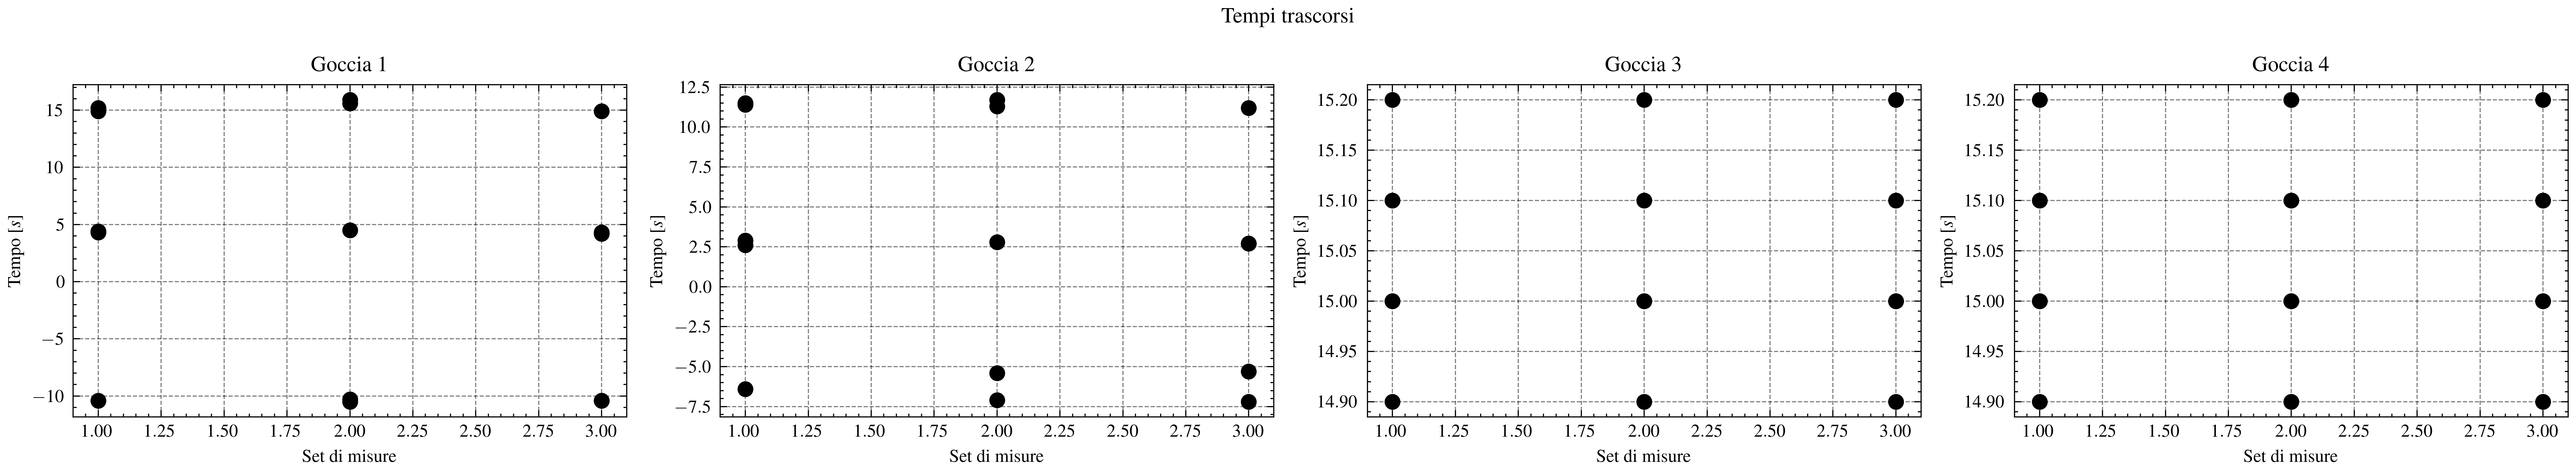

In [6]:
# Show data collected
X = np.repeat(np.arange(max_col) + 1, max_row, axis=0).reshape(max_col, max_row).T
fig, axs = plt.subplots(1, max_sheets, figsize=(4 * max_sheets, 3))
plt.suptitle("Tempi trascorsi")
for i in range(max_sheets):
    axs[i].scatter(X, tempi[i, :max_col, :max_row])
    axs[i].title.set_text(f"Goccia {i+1}")
    axs[i].set_xlabel("Set di misure")
    axs[i].set_ylabel(r"Tempo [$s$]")

plt.tight_layout()
plt.savefig("Images/Tempi trascorsi.svg")
plt.show()

In [7]:
charges = np.zeros((max_sheets, max_col - 1))

for i in range(0, max_sheets):
    # Tempi
    print(f"~~~~~~~ Goccia {i+1} ~~~~~~~")
    means_t, stds_t = calc_stats(tempi[i, :max_col, :max_row])
    print(
        f"Tempi e incertezza per set: \n\t"
        + "\n\t".join(f"{a:.4g} {b:.2g}" for a, b in zip(means_t, stds_t))
    )

    # Velocità
    velocità = (reticolo / 1000) / means_t
    print(
        f"Velocità e incertezza per set: \n\t"
        + "\n\t".join(f"{a:.4g} {'Not calculated'}" for a, b in zip(velocità, stds_t))
    )

    # Raggio
    nu = calc_visco(temperatura[i, 0])
    r = calc_radius(nu, pressione[i, :max_col] * conv_atm_Pa, velocità)
    mean_r, std_r = r.mean(), r.std(ddof=1)

    print(f"nu: {nu:.4g}")
    print(f"Raggio: {mean_r:.4g} {std_r:.2g}")

    # Carica
    E = voltaggio[i, 1:max_col] / (d_isolante * 1000)
    print(
        f"Campo elettrico per set (2-{max_col}): \n\t" + "\n\t".join(f"{e}" for e in E)
    )

    q = calc_charge(mean_r, velocità[0], E, velocità[1:])
    print(
        f"Carica e incertezza per set (2-{max_col}): \n\t"
        + "\n\t".join(f"{a:.4g} {'Not calculated'}" for a, b in zip(q, stds_t[1:]))
    )
    charges[i] += q

~~~~~~~ Goccia 1 ~~~~~~~
Tempi e incertezza per set: 
	15.3 0.44
	4.34 0.11
	-10.4 0.071
Velocità e incertezza per set: 
	3.268e-05 Not calculated
	0.0001152 Not calculated
	-4.808e-05 Not calculated
nu: 1.833e-05
Raggio: 7.326e-07 2.6e-07
Campo elettrico per set (2-3): 
	0.039473684210526314
	-0.039473684210526314
Carica e incertezza per set (2-3): 
	-1.59e-12 Not calculated
	-1.655e-13 Not calculated
~~~~~~~ Goccia 2 ~~~~~~~
Tempi e incertezza per set: 
	11.42 0.19
	2.74 0.11
	-6.28 0.9
Velocità e incertezza per set: 
	4.378e-05 Not calculated
	0.0001825 Not calculated
	-7.962e-05 Not calculated
nu: 1.833e-05
Raggio: 9.193e-07 3.5e-07
Campo elettrico per set (2-3): 
	0.02631578947368421
	-0.02631578947368421
Carica e incertezza per set (2-3): 
	-5.381e-12 Not calculated
	-8.522e-13 Not calculated
~~~~~~~ Goccia 3 ~~~~~~~
Tempi e incertezza per set: 
	15.04 0.11
	15.04 0.11
	15.04 0.11
Velocità e incertezza per set: 
	3.324e-05 Not calculated
	3.324e-05 Not calculated
	3.324e-05 Not c

### Analisi della carica

-1.59e-12 -1.66e-13
-5.38e-12 -8.52e-13
-2.69e-13 2.69e-13
-2.69e-13 2.69e-13


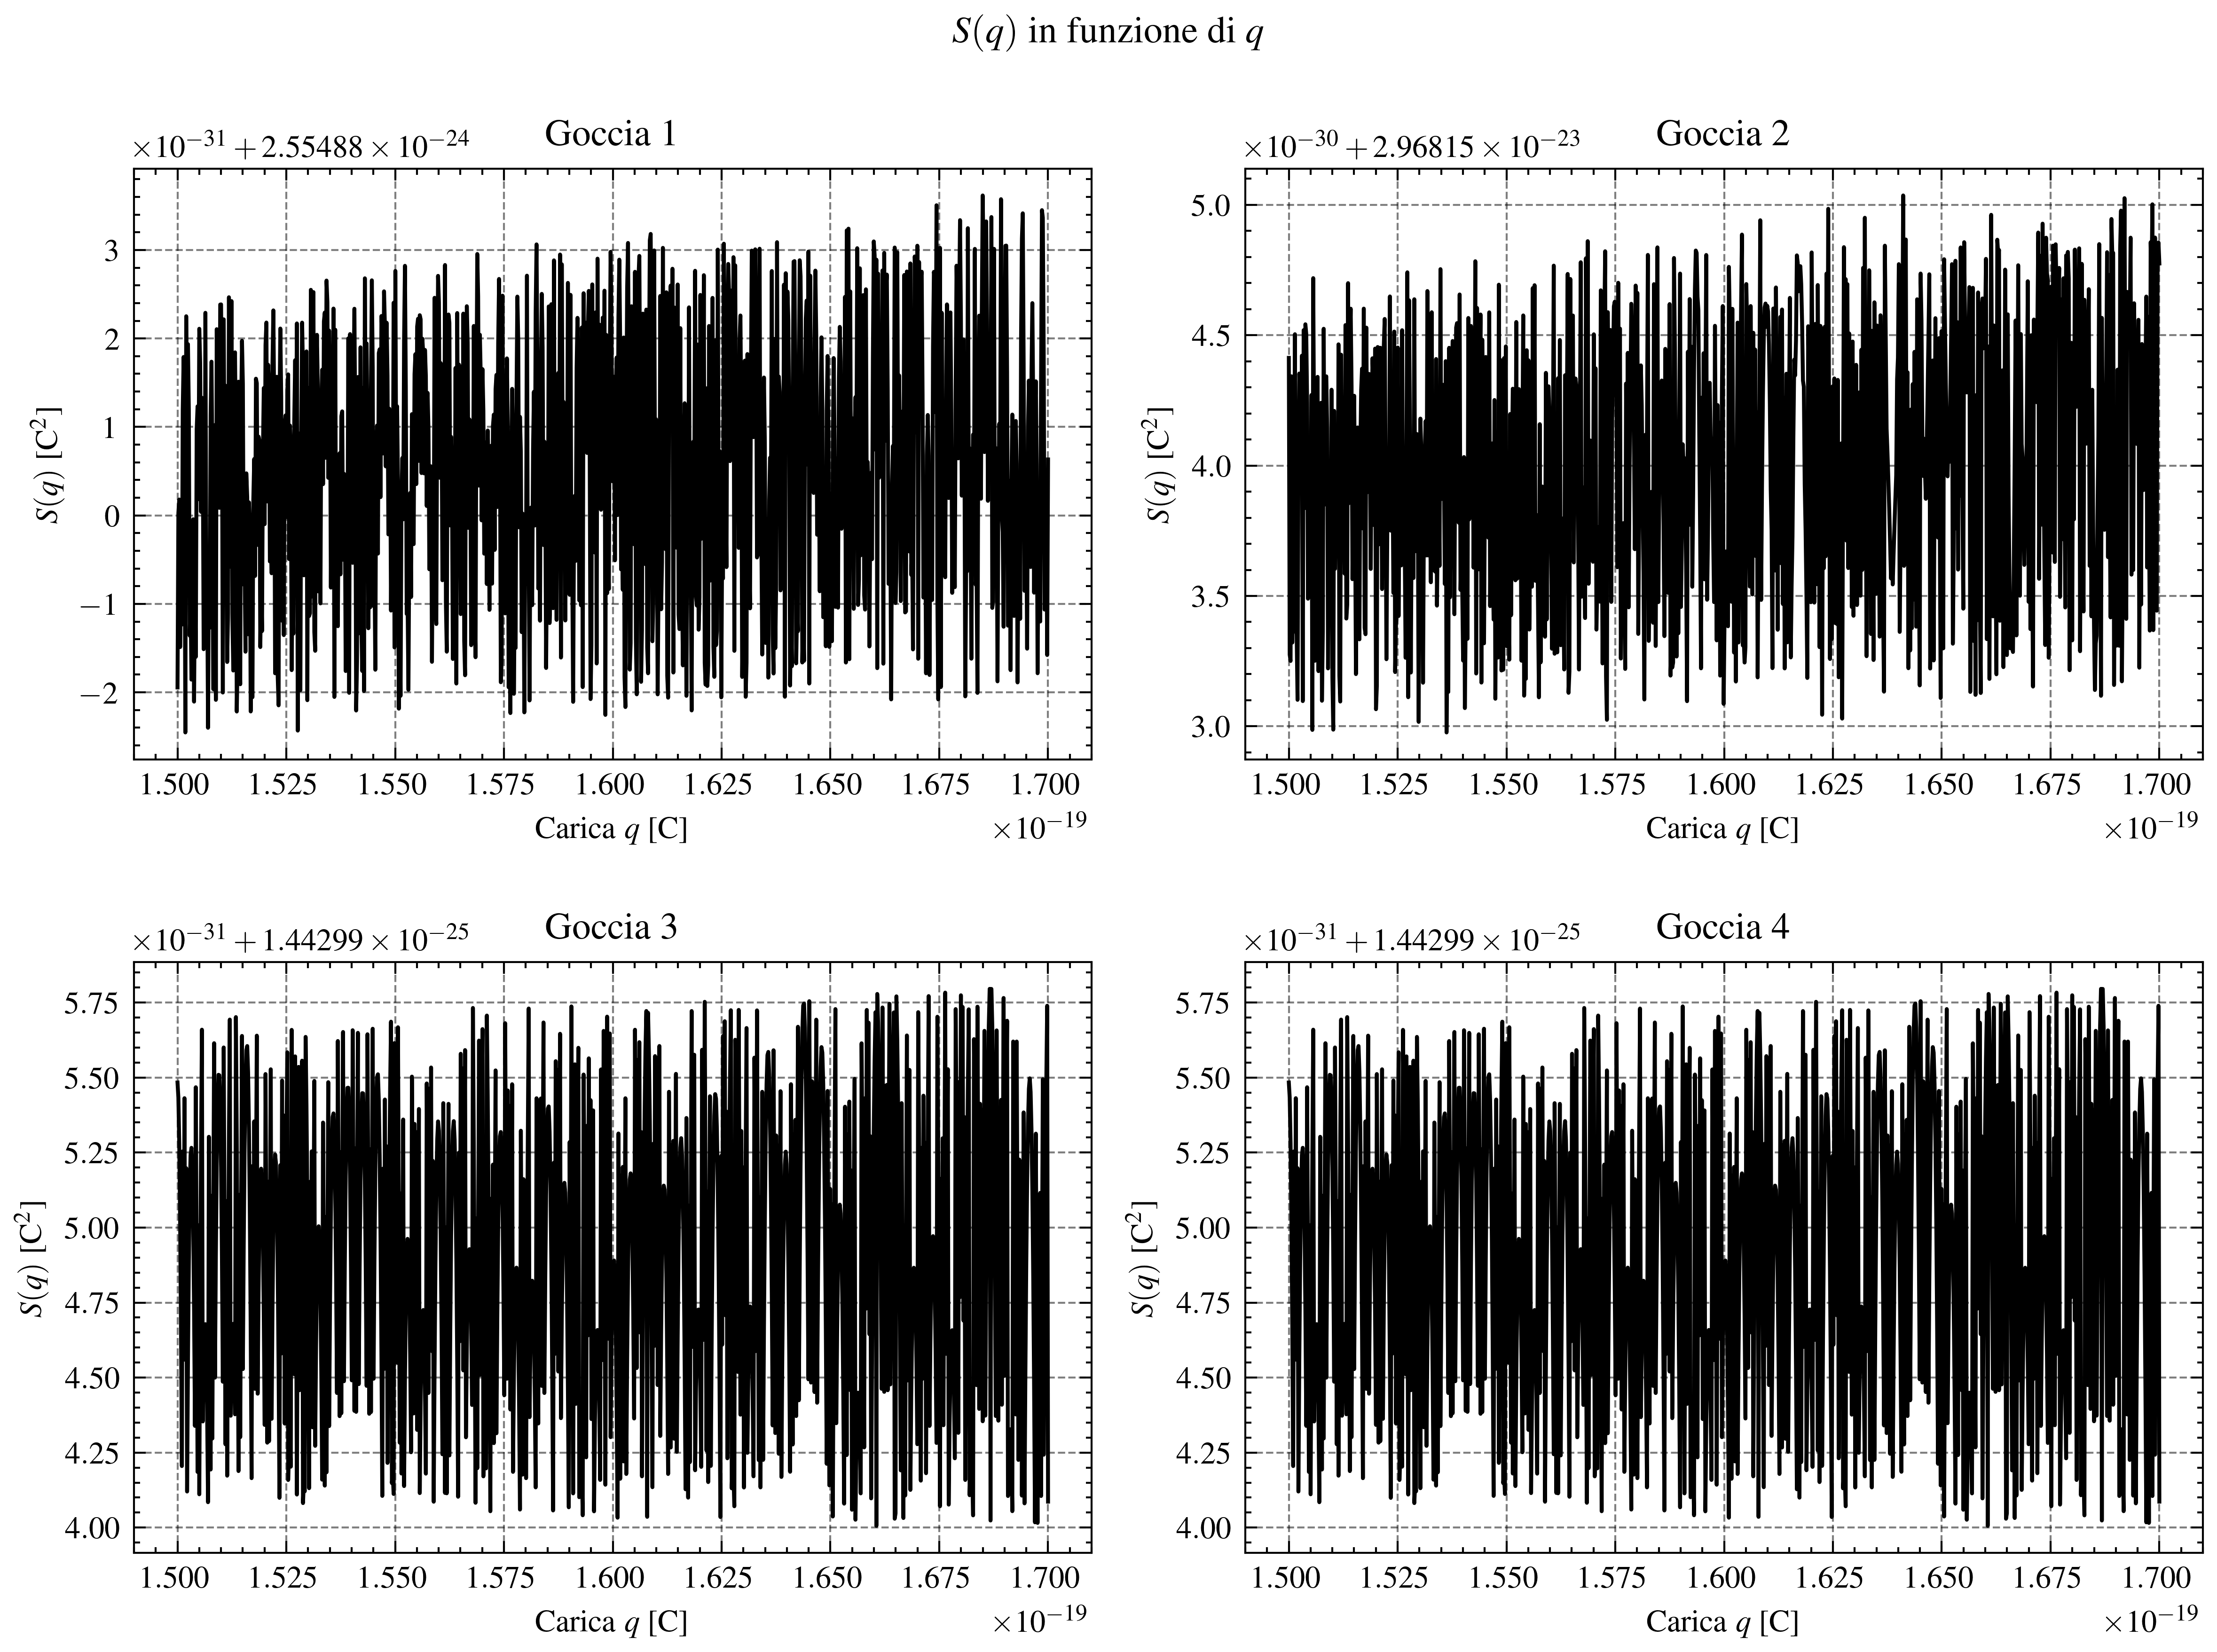

In [8]:
plot_row = np.ceil(np.sqrt(max_sheets)).astype(int)
plot_col = np.ceil(max_sheets / plot_row).astype(int)
fig, axs = plt.subplots(plot_col, plot_row, figsize=(plot_row * 4, plot_col * 3))

for i in range(max_sheets):
    x = np.linspace(1.5e-19, 1.7e-19, 1000)
    print(" ".join(f"{charge:.3g}" for charge in charges[i]))
    y = sum(np.square((np.round(charge / x) - 1) * x) for charge in charges[i])

    n, m = i // plot_row, i % plot_row
    axs[n, m].plot(x, y)

    axs[n, m].set_title(f"Goccia {i+1}")
    axs[n, m].set_xlabel(r"Carica $q$ [C]")
    axs[n, m].set_ylabel(r"$S(q)$ [C$^2$]")

plt.suptitle(r"$S(q)$ in funzione di $q$")
plt.tight_layout()
plt.savefig("Images/Carica delle gocce.svg")
plt.show()